In [1]:
import shap
import tensorflow as tf
from tensorflow.keras.models import load_model
import chrombpnet.training.utils.losses as losses
import chrombpnet.training.utils.one_hot as one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import chrombpnet.evaluation.interpret.input_utils as input_utils
import viz_sequence 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

tf.compat.v1.disable_eager_execution()

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

In [2]:
# ---- Step 1: Load model ----

def load_model_wrapper(model_h5):
    # read .h5 model
    custom_objects={"multinomial_nll":losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_h5, compile=False)
    #model.summary()
    return model

MODEL_PATH = "results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"  # Change this path to your actual model
model = load_model_wrapper(MODEL_PATH)

2025-07-10 17:29:03.065500: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 17:29:03.989488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
# ---- Step 2: Input your custom 2114bp sequence ----

# Make sure it only contains A, C, G, T
def load_sequences_from_fasta(fasta_path):
    sequences = []
    with open(fasta_path) as f:
        current_seq = []
        for line in f:
            if line.startswith(">"):
                if current_seq:
                    sequences.append("".join(current_seq))
                    current_seq = []
            else:
                current_seq.append(line.strip())
                
        if current_seq:
            assert len("".join(current_seq)) == 2114, "Input sequence must be exactly 2114 bp long."
            sequences.append("".join(current_seq))
    return sequences
    
sequences = load_sequences_from_fasta("example.fa")

In [4]:
# ---- Step 3: One-hot encode the sequence ----

one_hot_seqs = one_hot.dna_to_one_hot(sequences)  # shape: (N, 2114, 4)
print("One-hot shape:", one_hot_seqs.shape)


One-hot shape: (2, 2114, 4)


In [5]:
# Get count shap scores
counts_model_input = model.input
counts_input = one_hot_seqs

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
    shap_utils.shuffle_several_times,
    combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

#  counts_shap_scores has final hypothetical contribution scores from counts head
print("Generating 'counts' shap scores")
counts_shap_scores = profile_model_counts_explainer.shap_values(
    counts_input, progress_message=100) 


Generating 'counts' shap scores
Done 0 examples of 2


2025-07-10 17:29:07.290598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [6]:
counts_shap_scores.shape

(2, 2114, 4)

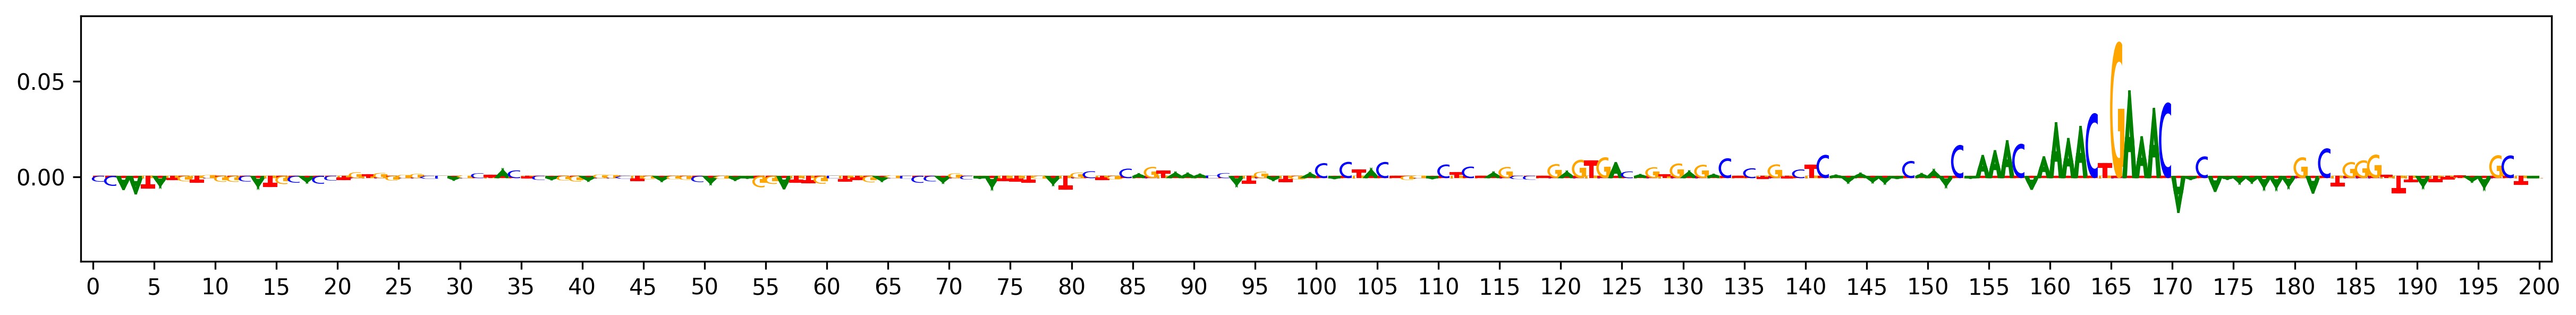

In [7]:

index=0 # plot contributions for example 0

#  Multiple counts_shap_scores with one_hot_seqs to get observed shap scores on counts head

observed_counts_scores = counts_shap_scores * one_hot_seqs

ymin = counts_shap_scores[index].min()
ymax = counts_shap_scores[index].max()
viz_sequence.plot_weights(observed_counts_scores[index, 1057-100:1057+100,:],subticks_frequency=5,ylim=[ymin,ymax])
plt.show() 
    

In [8]:
# Get profile shap scores

profile_model_input = model.input
profile_input = one_hot_seqs

weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    (profile_model_input, weightedsum_meannormed_logits),
    shap_utils.shuffle_several_times,
    combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

#  profile_shap_scores has final hypothetical contribution scores from profile head
print("Generating 'profile' shap scores")
profile_shap_scores = profile_model_profile_explainer.shap_values(
    profile_input, progress_message=100)

Generating 'profile' shap scores
Done 0 examples of 2


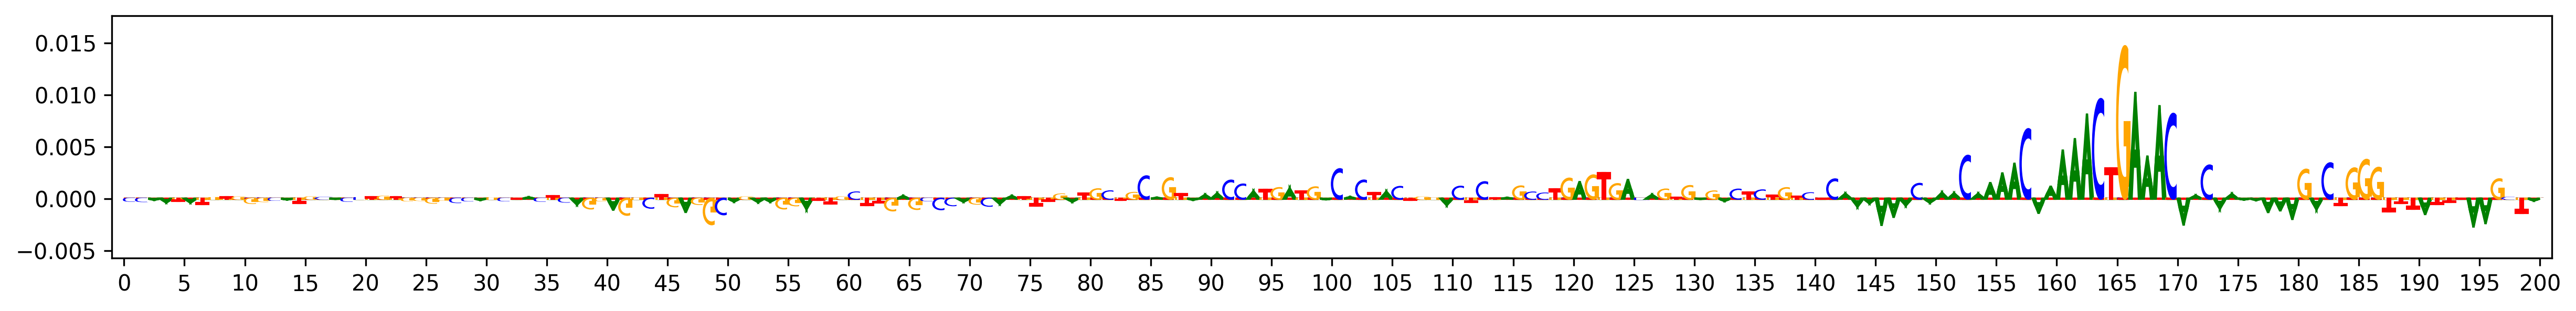

In [9]:
index=0 # plot contributions for example 0

#  Multiple profile_shap_scores with one_hot_seqs to get observed shap scores on profile head

observed_profile_scores = profile_shap_scores * one_hot_seqs

ymin = observed_profile_scores[index].min()
ymax = observed_profile_scores[index].max()
viz_sequence.plot_weights(observed_profile_scores[index, 1057-100:1057+100,:],subticks_frequency=5,ylim=[ymin,ymax])
plt.show() 
    